# Tools and Routing

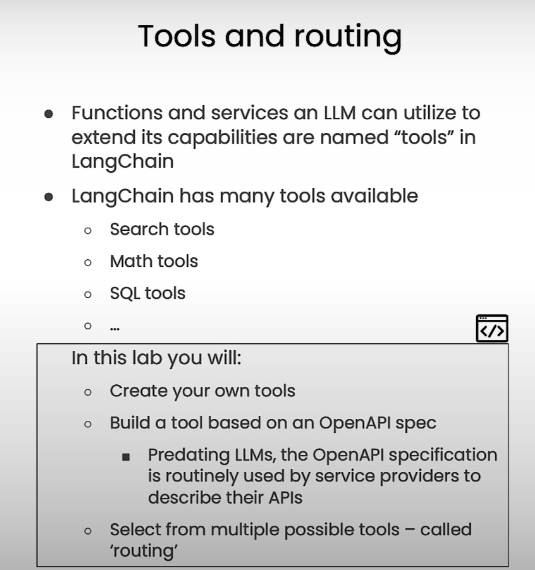

In [1]:
from langchain_core.tools import tool

In [2]:
@tool
def search(query: str) -> str:
    """Search for weather online"""
    return "42f"

In [3]:
search

StructuredTool(name='search', description='Search for weather online', args_schema=<class 'pydantic.main.searchSchema'>, func=<function search at 0x7f701d9708b0>)

In [4]:
search.name

'search'

In [5]:
search.description

'Search for weather online'

In [6]:
search.args

{'query': {'title': 'Query', 'type': 'string'}}

In [7]:
from pydantic import BaseModel, Field
class SearchInput(BaseModel):
    query: str = Field(description="Thing to search for")


In [8]:
@tool(args_schema=SearchInput)
def search(query: str) -> str:
    """Search for the weather online."""
    return "42f"

In [9]:
search.args

{'query': {'title': 'Query',
  'description': 'Thing to search for',
  'type': 'string'}}

In [10]:
search.run("kl")

'42f'

In [11]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.now()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [12]:
get_current_temperature.name

'get_current_temperature'

In [13]:
get_current_temperature.description

'Fetch current temperature for given coordinates.'

In [14]:
get_current_temperature.args

{'latitude': {'title': 'Latitude',
  'description': 'Latitude of the location to fetch weather data for',
  'type': 'number'},
 'longitude': {'title': 'Longitude',
  'description': 'Longitude of the location to fetch weather data for',
  'type': 'number'}}

In [15]:
from langchain_core.utils.function_calling import convert_to_openai_function

In [16]:
convert_to_openai_function(get_current_temperature)

{'name': 'get_current_temperature',
 'description': 'Fetch current temperature for given coordinates.',
 'parameters': {'type': 'object',
  'properties': {'latitude': {'description': 'Latitude of the location to fetch weather data for',
    'type': 'number'},
   'longitude': {'description': 'Longitude of the location to fetch weather data for',
    'type': 'number'}},
  'required': ['latitude', 'longitude']}}

In [17]:
get_current_temperature.invoke({"latitude": 13, "longitude": 14})

'The current temperature is 23.9°C'

In [18]:
import wikipedia
@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [19]:
search_wikipedia.name

'search_wikipedia'

In [20]:
search_wikipedia.description

'Run Wikipedia search and get page summaries.'

In [21]:
convert_to_openai_function(search_wikipedia)

{'name': 'search_wikipedia',
 'description': 'Run Wikipedia search and get page summaries.',
 'parameters': {'type': 'object',
  'properties': {'query': {'type': 'string'}},
  'required': ['query']}}

In [22]:
search_wikipedia.invoke({"query": "langchain"})

"Page: LangChain\nSummary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\nPage: Retrieval-augmented generation\nSummary: Retrieval augmented generation (RAG) is a type of information retrieval process. It modifies interactions with a large language model (LLM) so that it responds to queries with reference to a specified set of documents, using it in preference to information drawn from its own vast, static training data. This allows LLMs to use domain-specific and/or updated information.  \nUse cases include providing chatbot access to internal company data, or giving factual information only from an authoritative source.\n\nPage: DataStax\nSummary: DataStax, Inc. is a real-time data for AI company based in Santa Clara, Cali

In [23]:
from langchain.chains.openai_functions.openapi import openapi_spec_to_openai_fn
from langchain.utilities.openapi import OpenAPISpec
from openapi_pydantic import OpenAPI, Info, PathItem, Operation, Response

So far what we have done is we have created functions in our notebook and then create OpenAI function definitions for those functions. 

Often times, functions that we want to interact with are exposed behind APIs and often times APIs have their specific specification for their input and output called open API specification..

So what we gonna to do is take one of these open API specifications and convert it into a list of open API function calls

In [24]:
text = """
{
  "openapi": "3.0.0",
  "info": {
    "version": "1.0.0",
    "title": "Swagger Petstore",
    "license": {
      "name": "MIT"
    }
  },
  "servers": [
    {
      "url": "http://petstore.swagger.io/v1"
    }
  ],
  "paths": {
    "/pets": {
      "get": {
        "summary": "List all pets",
        "operationId": "listPets",
        "tags": [
          "pets"
        ],
        "parameters": [
          {
            "name": "limit",
            "in": "query",
            "description": "How many items to return at one time (max 100)",
            "required": false,
            "schema": {
              "type": "integer",
              "maximum": 100,
              "format": "int32"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "A paged array of pets",
            "headers": {
              "x-next": {
                "description": "A link to the next page of responses",
                "schema": {
                  "type": "string"
                }
              }
            },
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Pets"
                }
              }
            }
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      },
      "post": {
        "summary": "Create a pet",
        "operationId": "createPets",
        "tags": [
          "pets"
        ],
        "responses": {
          "201": {
            "description": "Null response"
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      }
    },
    "/pets/{petId}": {
      "get": {
        "summary": "Info for a specific pet",
        "operationId": "showPetById",
        "tags": [
          "pets"
        ],
        "parameters": [
          {
            "name": "petId",
            "in": "path",
            "required": true,
            "description": "The id of the pet to retrieve",
            "schema": {
              "type": "string"
            }
          }
        ],
        "responses": {
          "200": {
            "description": "Expected response to a valid request",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Pet"
                }
              }
            }
          },
          "default": {
            "description": "unexpected error",
            "content": {
              "application/json": {
                "schema": {
                  "$ref": "#/components/schemas/Error"
                }
              }
            }
          }
        }
      }
    }
  },
  "components": {
    "schemas": {
      "Pet": {
        "type": "object",
        "required": [
          "id",
          "name"
        ],
        "properties": {
          "id": {
            "type": "integer",
            "format": "int64"
          },
          "name": {
            "type": "string"
          },
          "tag": {
            "type": "string"
          }
        }
      },
      "Pets": {
        "type": "array",
        "maxItems": 100,
        "items": {
          "$ref": "#/components/schemas/Pet"
        }
      },
      "Error": {
        "type": "object",
        "required": [
          "code",
          "message"
        ],
        "properties": {
          "code": {
            "type": "integer",
            "format": "int32"
          },
          "message": {
            "type": "string"
          }
        }
      }
    }
  }
}
"""

In [25]:
spec = OpenAPISpec.from_text(text)

Attempting to load an OpenAPI 3.0.0 spec.  This may result in degraded performance. Convert your OpenAPI spec to 3.1.* spec for better support.


In [26]:
# pet_callables is callables that we could actually call to invoke those functions, 
# this is a made-up spec, those callables aren't actually going to be real 
# if this was a real functioning spec, callables would be real functions that we could call
pet_openai_functions, pet_callables = openapi_spec_to_openai_fn(spec)

In [28]:
pet_callables

<function langchain.chains.openai_functions.openapi.openapi_spec_to_openai_fn.<locals>.default_call_api(name: 'str', fn_args: 'dict', headers: 'Optional[dict]' = None, params: 'Optional[dict]' = None, **kwargs: 'Any') -> 'Any'>

In [27]:
# function definitions
pet_openai_functions

[{'name': 'listPets',
  'description': 'List all pets',
  'parameters': {'type': 'object',
   'properties': {'params': {'type': 'object',
     'properties': {'limit': {'type': 'integer',
       'maximum': 100.0,
       'schema_format': 'int32',
       'description': 'How many items to return at one time (max 100)'}},
     'required': []}}}},
 {'name': 'createPets',
  'description': 'Create a pet',
  'parameters': {'type': 'object', 'properties': {}}},
 {'name': 'showPetById',
  'description': 'Info for a specific pet',
  'parameters': {'type': 'object',
   'properties': {'path_params': {'type': 'object',
     'properties': {'petId': {'type': 'string',
       'description': 'The id of the pet to retrieve'}},
     'required': ['petId']}}}}]

In [29]:
from langchain_openai import ChatOpenAI

In [30]:
model = ChatOpenAI(temperature=0).bind(functions=pet_openai_functions)

In [31]:
model.invoke("what are three pets names")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"params":{"limit":3}}', 'name': 'listPets'}}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 123, 'total_tokens': 139}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-4974b24b-b86d-4803-8ac2-20cd2c532f02-0', usage_metadata={'input_tokens': 123, 'output_tokens': 16, 'total_tokens': 139})

In [32]:
model.invoke("tell me about pet with id 42")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"path_params":{"petId":"42"}}', 'name': 'showPetById'}}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 126, 'total_tokens': 145}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-82c6105b-edd4-4f77-a366-7e594edce406-0', usage_metadata={'input_tokens': 126, 'output_tokens': 19, 'total_tokens': 145})

### Routing

In lesson 3, we show an example of function calling deciding between two candidate functions.

Given our tools above, let's format these as OpenAI functions and show this same behavior.

In [33]:
functions = [
    convert_to_openai_function(f) for f in [
        search_wikipedia, get_current_temperature
    ]
]
model = ChatOpenAI(temperature=0).bind(functions=functions)

In [34]:
model.invoke("what is the weather in sf right now")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 105, 'total_tokens': 130}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-df6dd6c4-88eb-4252-99c4-d3b70131a5f5-0', usage_metadata={'input_tokens': 105, 'output_tokens': 25, 'total_tokens': 130})

In [35]:
model.invoke("what is langchain")

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"Langchain"}', 'name': 'search_wikipedia'}}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 101, 'total_tokens': 117}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-87cf708f-2db2-4313-a00d-e2a5917c783d-0', usage_metadata={'input_tokens': 101, 'output_tokens': 16, 'total_tokens': 117})

In [36]:
from langchain.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model

In [37]:
chain.invoke({"input": "what is the weather in sf right now"})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"latitude":37.7749,"longitude":-122.4194}', 'name': 'get_current_temperature'}}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 113, 'total_tokens': 138}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-11d2df88-e1e8-4f15-b902-89388b412e77-0', usage_metadata={'input_tokens': 113, 'output_tokens': 25, 'total_tokens': 138})

In [38]:
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [39]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [46]:
result = chain.invoke({"input": "what is the weather in kl right now"})

In [47]:
type(result)

langchain_core.agents.AgentActionMessageLog

In [48]:
result.tool

'get_current_temperature'

In [49]:
result.tool_input

{'latitude': 3.139, 'longitude': 101.6869}

In [50]:
get_current_temperature.invoke(result.tool_input)

'The current temperature is 25.0°C'

In [51]:
result = chain.invoke({"input": "hi!"})

In [52]:
type(result)

langchain_core.agents.AgentFinish

In [53]:
result.return_values

{'output': 'Well, hello there! How can I assist you today?'}

In [54]:
from langchain_core.agents import AgentFinish
def route(result):
    if isinstance(result, AgentFinish):
        return result.return_values['output']
    else:
        tools = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }
        return tools[result.tool].run(result.tool_input)

In [55]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser() | route

In [63]:
result = chain.invoke({"input": "What is the weather in kuala lumpur right now?"})

In [64]:
result

'The current temperature is 25.3°C'

In [58]:
result = chain.invoke({"input": "What is langchain?"})

In [59]:
result

"Page: LangChain\nSummary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.\n\nPage: Retrieval-augmented generation\nSummary: Retrieval augmented generation (RAG) is a type of information retrieval process. It modifies interactions with a large language model (LLM) so that it responds to queries with reference to a specified set of documents, using it in preference to information drawn from its own vast, static training data. This allows LLMs to use domain-specific and/or updated information.  \nUse cases include providing chatbot access to internal company data, or giving factual information only from an authoritative source.\n\nPage: DataStax\nSummary: DataStax, Inc. is a real-time data for AI company based in Santa Clara, Cali

In [60]:
chain.invoke({"input": "hi!"})

'Well, hello there! How can I assist you today?'